<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Neural_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 5.2 MB/s 


In [ ]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [ ]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit

Data Pre-processing

In [ ]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [ ]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [ ]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [ ]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)

train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# trim start stage
train_df = train_df.iloc[21600:]


In [ ]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [ ]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [ ]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [ ]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

Model Prediction

In [ ]:
from  pyod.models.deep_svdd import DeepSVDD
start = timeit.default_timer()
model = DeepSVDD(preprocessing = False,epochs=100, batch_size=128, hidden_neurons=[64, 32])
model.fit(train_scale)
end = timeit.default_timer()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 51)]              0         
                                                                 
 dense_1 (Dense)             (None, 64)                3264      
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_1 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_1 (TFOpL  (None,)                  0         
 ambda)                                                    

In [ ]:
print(f"Total training time {end-start} s")

Total training time 1007.845234733 s


In [ ]:
print(model.model_)

In [ ]:
# get outlier scores
train_scores = model.decision_scores_  # raw outlier scores on the train data

start = timeit.default_timer()
test_scores = model.decision_function(test_scale)  # predict raw outlier scores on test
end = timeit.default_timer()

In [ ]:
print(f'Total prediction time {end-start} s')

Total prediction time 21.578090098999837 s


In [ ]:
pd.DataFrame(test_scores).describe()

0
count  449919.000000
mean     1698.450562
std      6053.856445
min         0.000017
25%         0.025042
50%         1.487612
75%         2.628818
max     24459.753906

In [ ]:
pd.DataFrame(train_scores).describe()

0
count  475200.000000
mean        0.022709
std         0.002189
min         0.000135
25%         0.021824
50%         0.022686
75%         0.023351
max         0.147432

In [ ]:
fpr, tpr, _ = metrics.roc_curve(label,  test_scores)
auc = metrics.roc_auc_score(label,  test_scores)

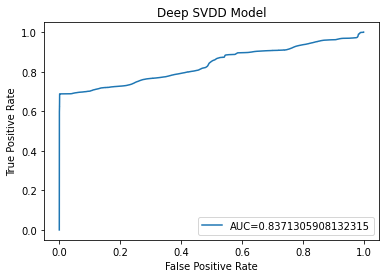

In [ ]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Deep SVDD Model')
plt.legend(loc=4)
plt.show()

In [ ]:
np.any(np.isnan(test_scores)),np.all(np.isfinite(test_scores))

(False, True)

In [ ]:
#normalise error score
min_train = min(train_scores)
max_train = max(train_scores)
norm_train = (train_scores-min_train)/(max_train-min_train)

In [ ]:
norm_test = (test_scores - min_train)/(max_train-min_train)

In [ ]:
df_error_train = pd.DataFrame(norm_train,columns = ['error'])
df_error_train['type'] = 'train'
df_error_test = pd.DataFrame(norm_test,columns = ['error'])
df_error_test['type'] = 'test'

pd.concat([df_error_train,df_error_test]).to_csv("/content/drive/MyDrive/Data_sci_Project/error.csv")

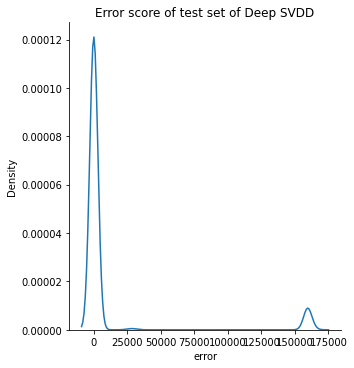

In [ ]:
# sns.displot(df_error_train, x="error",kind="kde")
sns.displot(df_error_test, x="error",kind="kde")
plt.title("Error score of test set of Deep SVDD")
plt.show()

In [ ]:
threshold= np.percentile(norm_test,95)
threshold

252.46305969238279

In [ ]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    pred_label[i:i+time_window] = 0
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
  return pred_label

In [ ]:
time_window = 10
pred_label = pred_labels_timewindow(norm_test,threshold,time_window)

In [ ]:
print(metrics.classification_report(label,pred_label))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    395298
           1       0.99      0.65      0.79     54621

    accuracy                           0.96    449919
   macro avg       0.97      0.83      0.88    449919
weighted avg       0.96      0.96      0.95    449919



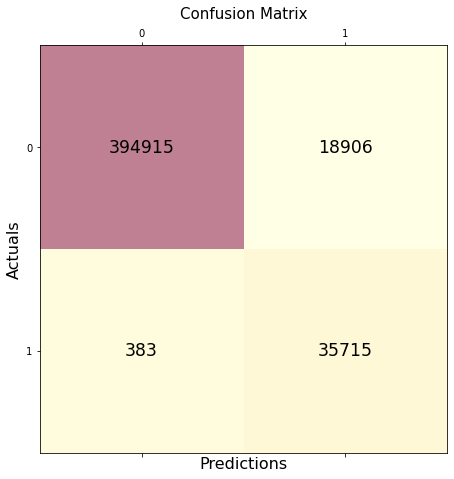

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label,pred_label)

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cm, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cm.shape[0]):
    for n in range(cm.shape[1]):
        px.text(x=m,y=n,s=cm[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [ ]:
time_label = pd.DataFrame(pred_label, index= test_df.index, columns = ['pred'])

In [ ]:
time_label['label'] = label
time_label.reset_index(inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label.Timestamp)

true anomaly

In [ ]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [ ]:
start_time = true_anomaly['Start Time'][~true_anomaly["End Time"].isnull()]
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [ ]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [ ]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [ ]:
attack_lenght

0       939
1       442
2       382
3       389
5       195
6       428
7       963
9       160
10      560
12      232
13      430
15      275
16      716
18      258
19      394
20      720
21      462
22      696
23      320
24      611
25     1444
26     1690
27    34208
28      120
29     1170
30      366
31      600
32      443
33      100
34      480
35      539
36      468
37      280
38      400
39      296
40     1674
dtype: int64

In [ ]:
len(start_time) #there are 36 attack

36

In [ ]:
start_time.index.values+1

array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41])

In [ ]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [ ]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]+1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'normal/attack')

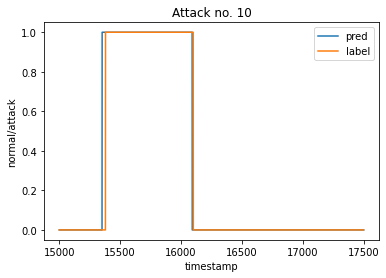

In [ ]:
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["pred"])
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["label"])
plt.title('Attack no. 10')
plt.legend(["pred", "label"])
plt.xlabel("timestamp")
plt.ylabel("normal/attack")

Text(0.5, 1.0, 'attack 1-8')

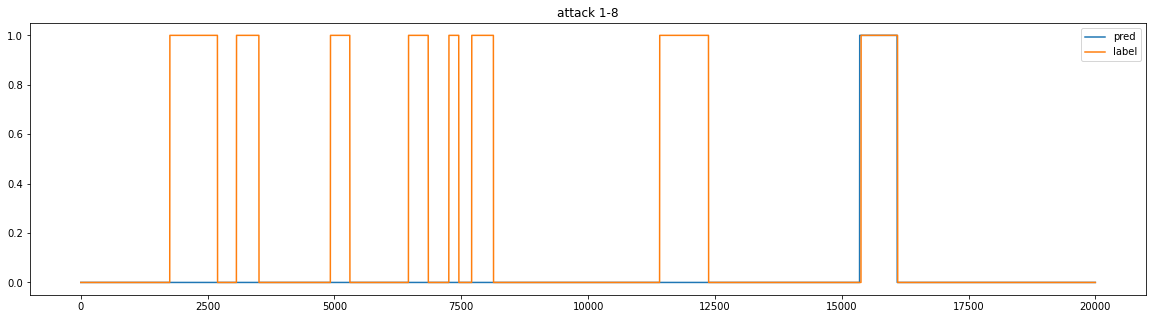

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[:20000],time_label["pred"][:20000])
plt.plot(time_label.index[:20000],time_label["label"][:20000])
plt.legend(["pred", "label"])
plt.title('attack 1-8')

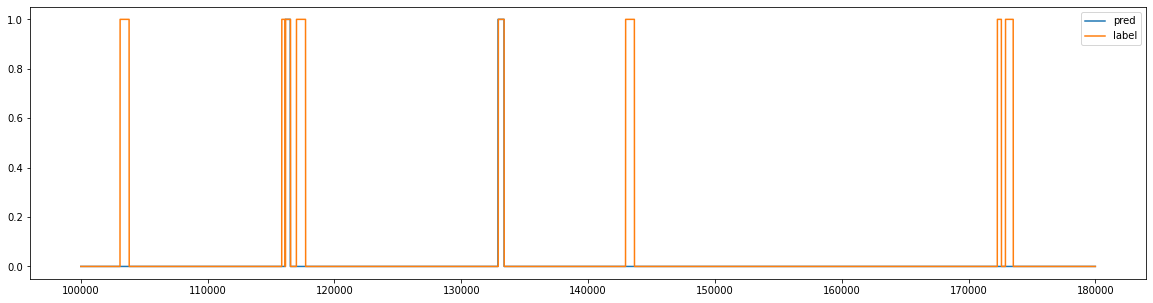

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[100000:180000],time_label["pred"][100000:180000])
plt.plot(time_label.index[100000:180000],time_label["label"][100000:180000])
plt.legend(["pred", "label"])

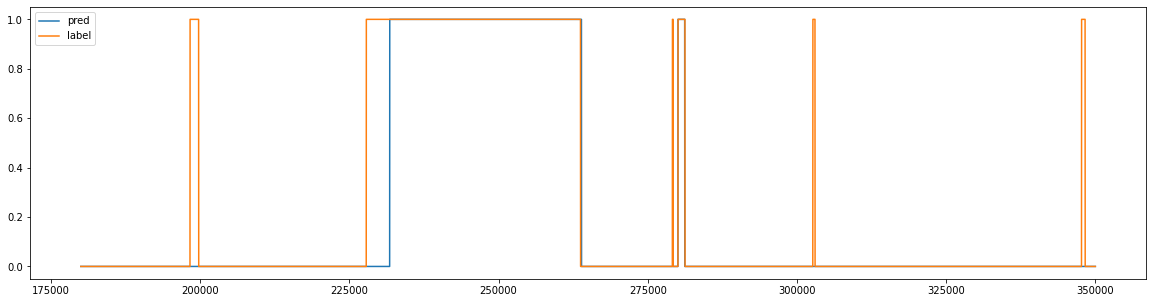

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[180000:350000],time_label["pred"][180000:350000])
plt.plot(time_label.index[180000:350000],time_label["label"][180000:350000])
plt.legend(["pred", "label"])

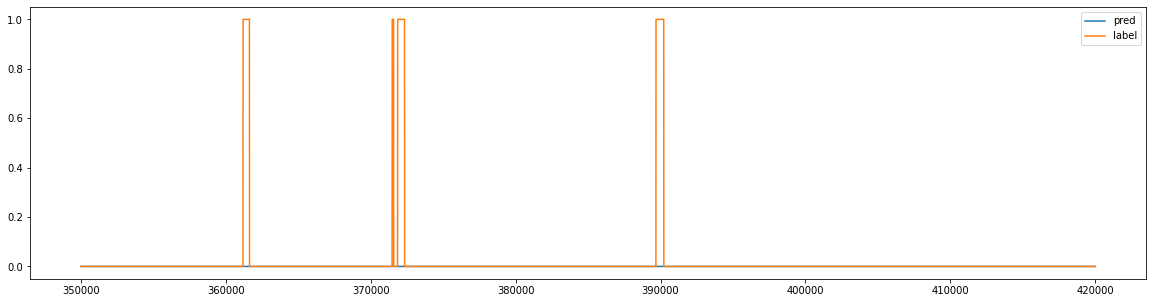

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[350000:420000],time_label["pred"][350000:420000])
plt.plot(time_label.index[350000:420000],time_label["label"][350000:420000])
plt.legend(["pred", "label"])

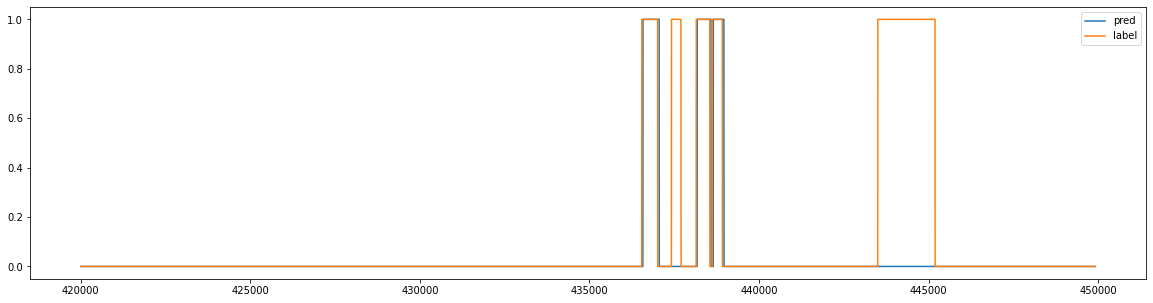

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[420000:],time_label["pred"][420000:])
plt.plot(time_label.index[420000:],time_label["label"][420000:])
plt.legend(["pred", "label"])

Find attack no. that model found

In [ ]:
found = []
for i in range(len(time_label)):
  if (time_label.loc[i]["pred"] == 1) & (time_label.loc[i]["label"] == 1):
    found.append(time_label.loc[i]["attack #"])

In [ ]:
np.unique(found)

array([10, 11, 20, 22, 28, 30, 37, 39, 40])

In [ ]:
print(f"There are {len(np.unique(found))} attacks found")

There are 9 attacks found


Apply XAI

##CASE STUDY attack no.1
model cannot detect the anomaly point

### SHAP

In [ ]:
!pip install shap --quiet

     |████████████████████████████████| 569 kB 5.2 MB/s 


In [ ]:
import shap

In [ ]:
#summarize all the train data using shap.kmeans
X_train_summary = shap.kmeans(train_scale, 50)

In [ ]:
shap_explainer = shap.KernelExplainer(model=model.model_.predict, data=X_train_summary)

In [ ]:
#attack no.1
#sample data  in attack no.1 for 100 instance
sample = shap.sample(test_scale[idx_start[0]:idx_end[0]], 100)

In [ ]:
np.any(np.isnan(sample)), np.all(np.isfinite(sample))

(False, True)

In [ ]:
start = timeit.default_timer()
shap_values_1 = shap_explainer.shap_values(X=sample, nsamples=100)
end = timeit.default_timer()

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
print(end-start)

53.51022658399984


Single value

In [ ]:
sample1 = shap.sample(test_scale[idx_start[0]:idx_end[0]], 1)

In [ ]:
start = timeit.default_timer()
shap_value_single = shap_explainer.shap_values(X = sample1, nsamples = 100)
end = timeit.default_timer()

  0%|          | 0/1 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [ ]:
print(end-start)

0.5475250320000669


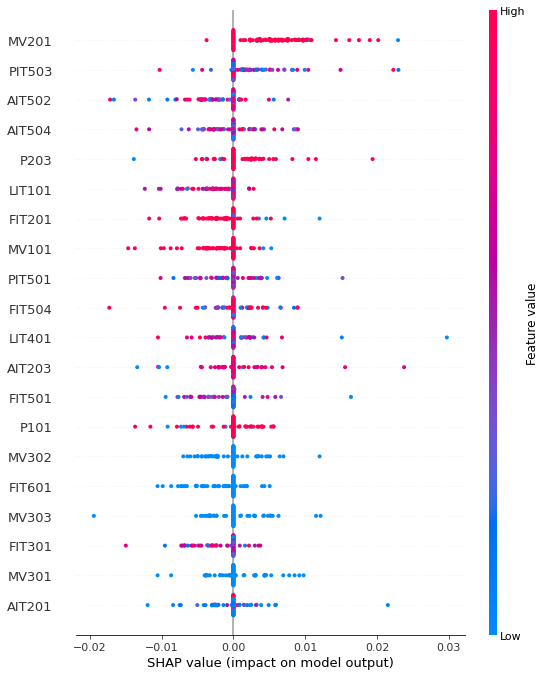

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_1, sample)

In [ ]:
shap_result = pd.DataFrame(np.mean(shap_values_1,axis=0), index= train_scale.columns, columns = ["result"])
shap_result.sort_values(by = ["result"])

result
LIT101  -0.001601
AIT502  -0.001542
MV101   -0.001262
FIT301  -0.001120
P205    -0.001037
FIT601  -0.001019
FIT201  -0.000928
FIT501  -0.000685
DPIT301 -0.000577
P101    -0.000373
FIT502  -0.000318
AIT503  -0.000261
AIT401  -0.000257
FIT401  -0.000257
MV302   -0.000249
PIT501  -0.000229
P602    -0.000169
AIT201  -0.000155
LIT301  -0.000154
PIT502  -0.000152
AIT504  -0.000151
P302    -0.000074
AIT202  -0.000032
P404     0.000000
P502     0.000000
P601     0.000000
P501     0.000000
P403     0.000000
UV401    0.000000
P402     0.000000
P603     0.000000
P102     0.000000
P301     0.000000
P201     0.000000
P206     0.000000
P204     0.000000
P401     0.000000
P202     0.000000
MV303    0.000042
AIT203   0.000056
MV304    0.000079
FIT504   0.000086
LIT401   0.000225
FIT503   0.000232
MV301    0.000332
AIT501   0.000445
AIT402   0.000551
FIT101   0.000587
P203     0.000705
PIT503   0.001742
MV201    0.004740

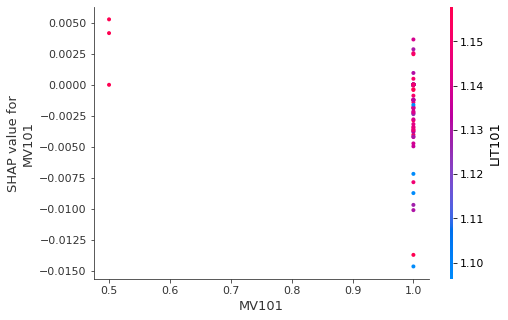

In [ ]:
shap.dependence_plot("MV101", shap_values_1, sample)

### LIME

In [ ]:
!pip install lime --quiet

     |████████████████████████████████| 275 kB 5.0 MB/s 


In [ ]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [ ]:
lime = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')

In [ ]:
start = timeit.default_timer()
a = lime.explain_instance(sample.iloc[10], model.decision_function, num_features=20)
end = timeit.default_timer()

Intercept 0.5430334520410895
Prediction_local [0.09724303]
Right: 0.020412963


In [ ]:
print(end-start)

27.600677597999947


In [ ]:
a.show_in_notebook(show_table=False)

In [ ]:
start = timeit.default_timer()
sp_obj = submodular_pick.SubmodularPick(lime, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()

Requested sample size larger than
                              size of input data. Using all data


Intercept 0.45932652639397353
Prediction_local [0.21744594]
Right: 0.020880219
Intercept 0.6260572848498174
Prediction_local [0.15135893]
Right: 0.021080242
Intercept 0.5744239362276724
Prediction_local [0.149901]
Right: 0.020849664
Intercept 0.5167386415148258
Prediction_local [0.08613945]
Right: 0.020738445
Intercept 0.5729835260904265
Prediction_local [0.16943252]
Right: 0.021063812
Intercept 0.48604192701061233
Prediction_local [0.22055527]
Right: 0.02082932
Intercept 0.7203370664088553
Prediction_local [0.15804157]
Right: 0.020463075
Intercept 0.4694090583790782
Prediction_local [0.11925763]
Right: 0.020865358
Intercept 0.6507053990667795
Prediction_local [0.12277962]
Right: 0.020708978
Intercept 0.6656579597921215
Prediction_local [0.19319627]
Right: 0.020947788
Intercept 0.5512168176624741
Prediction_local [0.19281085]
Right: 0.02093171
Intercept 0.5146246577577243
Prediction_local [0.17539423]
Right: 0.020703688
Intercept 0.544501033454079
Prediction_local [-0.0107636]
Right: 0

In [ ]:
print(end-start)

2266.597116643


[<Figure size 432x288 with 1 Axes>]

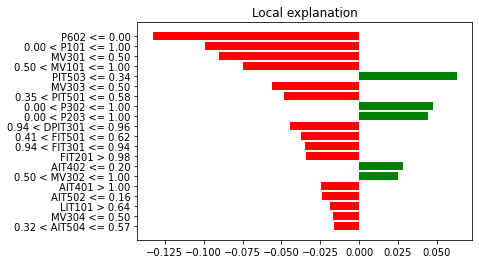

In [ ]:
[exp.as_pyplot_figure(label=0) for exp in sp_obj.sp_explanations]

In [ ]:
sp_obj.sp_explanations[0].as_list()

[('P602 <= 0.00', -0.13284730334352104),
 ('0.00 < P101 <= 1.00', -0.09900973795083914),
 ('MV301 <= 0.50', -0.09039470554293456),
 ('0.50 < MV101 <= 1.00', -0.07492907999830822),
 ('PIT503 <= 0.34', 0.06302245309351286),
 ('MV303 <= 0.50', -0.05609241665804565),
 ('0.35 < PIT501 <= 0.58', -0.048160649983613),
 ('0.00 < P302 <= 1.00', 0.047629529485224906),
 ('0.00 < P203 <= 1.00', 0.0444243531802237),
 ('0.94 < DPIT301 <= 0.96', -0.0442122613446892),
 ('0.41 < FIT501 <= 0.62', -0.03713869977176564),
 ('0.94 < FIT301 <= 0.94', -0.03468527738500477),
 ('FIT201 > 0.98', -0.03448609245962351),
 ('AIT402 <= 0.20', 0.028204294804669506),
 ('0.50 < MV302 <= 1.00', 0.02527705549224252),
 ('AIT401 > 1.00', -0.024768223886311513),
 ('AIT502 <= 0.16', -0.024086464582791612),
 ('LIT101 > 0.64', -0.018522919015488234),
 ('MV304 <= 0.50', -0.01677339182286592),
 ('0.32 < AIT504 <= 0.57', -0.016271831480567597)]

###IntegratedGradients

In [ ]:
!pip install alibi[tensorflow] --quiet

     |████████████████████████████████| 445 kB 5.2 MB/s 
     |████████████████████████████████| 60 kB 6.8 MB/s 
     |████████████████████████████████| 4.7 MB 52.3 MB/s 
     |████████████████████████████████| 98.5 MB 164 kB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 6.6 MB 35.9 MB/s 
     |████████████████████████████████| 596 kB 57.0 MB/s 


In [ ]:
from alibi.explainers import IntegratedGradients
import tensorflow as tf

In [ ]:
ig  = IntegratedGradients(model.model_,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

In [ ]:
start = timeit.default_timer()
ig_explanation = ig.explain(sample.to_numpy(),
                         baselines=None,
                         target=[0]*len(sample))
end = timeit.default_timer()

In [ ]:
print(end-start)

5.3340155659998345


In [ ]:
attributions = ig_explanation.attributions

In [ ]:
ig_result = pd.DataFrame(np.mean(attributions[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result.sort_values(by = ["result"], ascending=False)

result
P302     2.296270
MV301    0.272149
MV302    0.209858
MV304    0.113150
MV201    0.079715
DPIT301  0.069009
P203     0.024962
LIT101   0.014844
MV101    0.013450
FIT504   0.008660
FIT401   0.007426
AIT504   0.006330
AIT501   0.004763
FIT503   0.004135
AIT401   0.004054
AIT201   0.003846
PIT502   0.002541
FIT502   0.002180
MV303    0.001307
PIT501   0.001291
FIT201   0.000577
FIT501   0.000547
AIT402   0.000328
FIT601   0.000126
AIT502   0.000109
P404     0.000000
P501     0.000000
P502     0.000000
P601     0.000000
P602     0.000000
UV401    0.000000
P603     0.000000
P403     0.000000
P201     0.000000
P401     0.000000
P102     0.000000
P301     0.000000
P206     0.000000
P402     0.000000
P204     0.000000
P202     0.000000
PIT503  -0.000170
LIT301  -0.000395
AIT203  -0.000728
P205    -0.001108
AIT202  -0.001162
AIT503  -0.002523
LIT401  -0.003649
FIT101  -0.006088
FIT301  -0.047506
P101    -0.056979

Text(0.5, 0, 'feature')

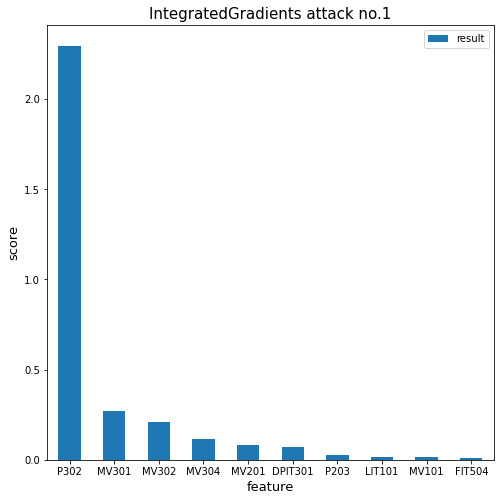

In [ ]:
ig_plot = ig_result.sort_values(by = ["result"], ascending=False)[0:10]
ig_plot.plot.bar(rot=0,figsize=(8, 8))
plt.title("IntegratedGradients attack no.1",size=15)
plt.ylabel("score",size=13)
plt.xlabel("feature",size=13)

single value

In [ ]:
start = timeit.default_timer()
ig_explanation = ig.explain(sample1.to_numpy(),
                         baselines=None,
                         target=[0]*len(sample1))
end = timeit.default_timer()

In [ ]:
print(end-start)

0.1797734209999362


In [ ]:
# type(model).__mro__

###ALE

In [ ]:
!pip install alibi[tensorflow] --quiet

In [ ]:
from alibi.explainers import ALE

In [ ]:
ale = ALE(model.decision_function, feature_names=train_scale.columns)

In [ ]:
start = timeit.default_timer()
exp_ale = ale.explain(sample.to_numpy())
end = timeit.default_timer()

In [ ]:
print(end-start)

7.314787112999966


In [ ]:
exp_ale.feature_names

array(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501',
       'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
       'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601',
       'P601', 'P602', 'P603'], dtype=object)

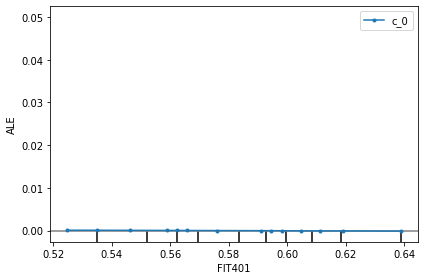

In [ ]:
from alibi.explainers import plot_ale
plot_ale(exp_ale, features = ['FIT401']);

In [ ]:
mean_ale = []
for e in exp_ale.ale_values:
  mean_ale.append(np.mean(e))

In [ ]:
ale_result = pd.DataFrame(mean_ale, index = train_scale.columns, columns = ["result"])

In [ ]:
ale_result.sort_values(by=['result'], ascending=False)

result
MV201    1.587902e-03
FIT201   4.974868e-05
AIT202   1.175262e-05
LIT101   5.983750e-06
PIT503   5.560454e-06
FIT504   4.013277e-06
AIT503   1.148761e-06
PIT502   1.125858e-06
AIT501   2.026931e-07
AIT502   7.484326e-08
FIT301   2.344559e-08
UV401    0.000000e+00
P401     0.000000e+00
P402     0.000000e+00
P403     0.000000e+00
P404     0.000000e+00
AIT401   0.000000e+00
P302     0.000000e+00
P502     0.000000e+00
FIT601   0.000000e+00
P601     0.000000e+00
P602     0.000000e+00
P501     0.000000e+00
P603     0.000000e+00
P301     0.000000e+00
P206     0.000000e+00
P201     0.000000e+00
P202     0.000000e+00
P203     0.000000e+00
MV101    0.000000e+00
MV304    0.000000e+00
P101     0.000000e+00
P205     0.000000e+00
P204     0.000000e+00
MV301    0.000000e+00
MV302    0.000000e+00
MV303    0.000000e+00
P102     0.000000e+00
LIT401  -1.531498e-07
FIT502  -3.242254e-07
AIT203  -7.153079e-07
AIT402  -8.663955e-07
LIT301  -1.012025e-06
FIT401  -2.461216e-06
DPIT301 -3.614241e-06
PIT501  -7.969885e-06
FIT501  -1.279245e-05
AIT201  -2.794895e-05
AIT504  -3.705334e-05
FIT503  -3.985561e-05
FIT101  -1.500323e-04

##CASE STUDY attack no.10
model can detect the anomaly point

###SHAP

In [ ]:
sample_9 = shap.sample(test_scale[idx_start[7]:idx_end[7]], 100)

In [ ]:
shap_value_9 = shap_explainer.shap_values(X = sample_9, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

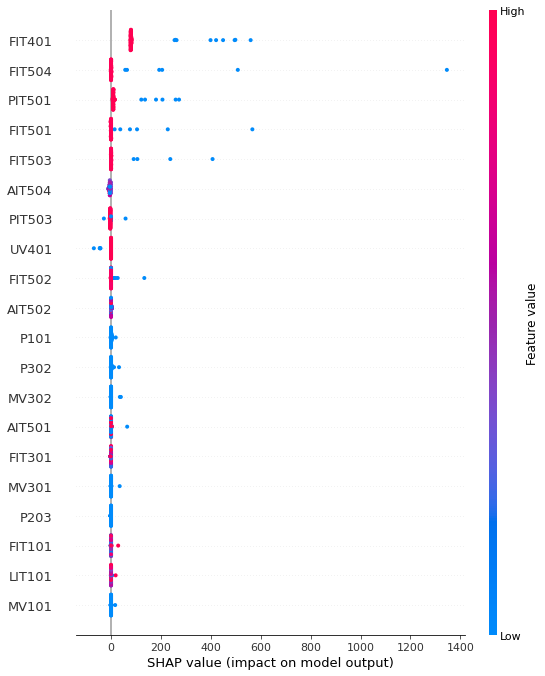

In [ ]:
shap.initjs()
shap.summary_plot(shap_value_9, sample_9)

In [ ]:
shap_result_9 = pd.DataFrame(np.mean(shap_value_9,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_9.sort_values(by = ["result"])

result
AIT504    -4.804210
PIT503    -2.557950
UV401     -2.448201
FIT301    -0.480171
P203      -0.413437
P602      -0.236071
P205      -0.047603
AIT203    -0.046803
MV303     -0.039744
AIT402    -0.029058
AIT201    -0.015362
LIT301    -0.009806
P402       0.000000
P403       0.000000
P301       0.000000
P502       0.000000
P401       0.000000
P603       0.000000
P206       0.000000
P204       0.000000
P202       0.000000
P201       0.000000
P102       0.000000
P601       0.000000
P404       0.000000
PIT502     0.006542
MV304      0.022530
MV201      0.074891
P501       0.085181
LIT401     0.088752
FIT201     0.101528
FIT601     0.148158
DPIT301    0.162679
MV101      0.191732
AIT401     0.210149
AIT202     0.212562
AIT503     0.214713
FIT101     0.233795
LIT101     0.316335
MV301      0.320002
MV302      0.681514
P302       0.796700
AIT501     0.811341
P101       0.893938
AIT502     1.095566
FIT502     1.976855
FIT503     8.455357
FIT501    10.147521
PIT501    19.707638
FIT504    23.796121
FIT401   108.498591

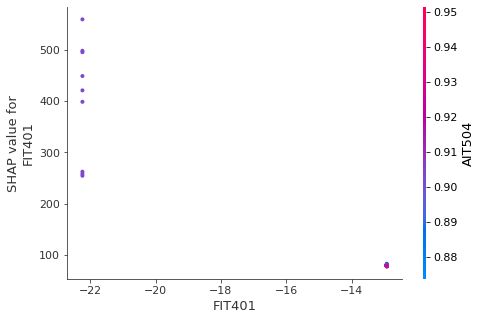

In [ ]:
shap.dependence_plot("FIT401", shap_value_9, sample_9)

###LIME

In [ ]:
sp_obj_9 = submodular_pick.SubmodularPick(lime, sample_9.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -0.05208111649640937
Prediction_local [1.76970699]
Right: 81.052025
Intercept 0.024791831651790663
Prediction_local [1.88051402]
Right: 81.360275
Intercept -0.09175370513937109
Prediction_local [1.77686111]
Right: 82.40616
Intercept -0.1803269257558522
Prediction_local [1.91455664]
Right: 82.0988
Intercept -0.025295326596201956
Prediction_local [1.80881973]
Right: 82.12305
Intercept -0.06134601617524793
Prediction_local [1.69709884]
Right: 83.1706
Intercept -0.09262510088816722
Prediction_local [1.71989173]
Right: 81.57559
Intercept 0.051174883040341124
Prediction_local [1.66268645]
Right: 81.97871
Intercept 0.07519322320904798
Prediction_local [1.65428811]
Right: 82.208374
Intercept 0.01587516792400248
Prediction_local [1.71701097]
Right: 82.42541
Intercept -0.10683003229757568
Prediction_local [1.80520014]
Right: 81.265816
Intercept -0.1503873161546633
Prediction_local [1.87258078]
Right: 81.94232
Intercept 0.0881199955519282
Prediction_local [1.80544599]
Right: 81.1246
Int

[<Figure size 432x288 with 1 Axes>]

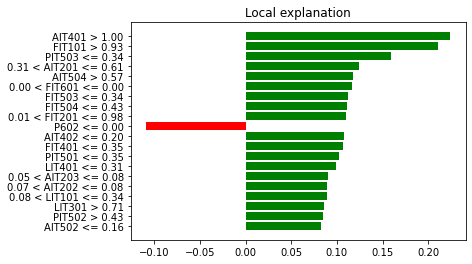

In [ ]:
[exp.as_pyplot_figure(label=1) for exp in sp_obj_9.sp_explanations]

In [ ]:
sp_obj_9.sp_explanations[0].as_list()

[('AIT401 > 1.00', 0.2239868422658294),
 ('FIT101 > 0.93', 0.21100873367694079),
 ('PIT503 <= 0.34', 0.15938553195867716),
 ('0.31 < AIT201 <= 0.61', 0.12407771591537471),
 ('AIT504 > 0.57', 0.11716917962392948),
 ('0.00 < FIT601 <= 0.00', 0.11699036252923169),
 ('FIT503 <= 0.34', 0.11252615441879255),
 ('FIT504 <= 0.43', 0.1106728405508608),
 ('0.01 < FIT201 <= 0.98', 0.10995060790230926),
 ('P602 <= 0.00', -0.1089217475325441),
 ('AIT402 <= 0.20', 0.10723920382393348),
 ('FIT401 <= 0.35', 0.10668197055931812),
 ('PIT501 <= 0.35', 0.10172985741802566),
 ('LIT401 <= 0.31', 0.09946955489547825),
 ('0.05 < AIT203 <= 0.08', 0.0904040620809726),
 ('0.07 < AIT202 <= 0.08', 0.08957255461441754),
 ('0.08 < LIT101 <= 0.34', 0.08909601959961663),
 ('LIT301 > 0.71', 0.08582696476208396),
 ('PIT502 > 0.43', 0.08467234075533253),
 ('AIT502 <= 0.16', 0.08255259941434295)]

### Intergrate Gredient

In [ ]:
ig_explanation_9 = ig.explain(sample_9.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_9))

In [ ]:
attributions_9 = ig_explanation_9.attributions

In [ ]:
ig_result_9 = pd.DataFrame(np.mean(attributions_9[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_9.sort_values(by = ["result"])

result
AIT504    -9.784359
FIT301    -5.447213
MV302     -4.017172
UV401     -3.127329
P203      -2.916387
MV304     -1.809063
AIT501    -1.206241
FIT101    -1.048731
MV101     -1.026773
P205      -1.006446
LIT301    -0.902436
AIT201    -0.675787
AIT502    -0.659150
AIT401    -0.342993
PIT502    -0.242691
LIT101    -0.089870
AIT402    -0.068485
AIT202    -0.053990
FIT601    -0.000837
P202       0.000000
P601       0.000000
P502       0.000000
P102       0.000000
P204       0.000000
P403       0.000000
P402       0.000000
P401       0.000000
P404       0.000000
P603       0.000000
P602       0.000000
P206       0.000000
P301       0.000000
P201       0.000000
AIT203     0.015600
LIT401     0.043356
P501       0.558610
FIT201     0.688843
FIT502     0.689964
MV301      1.374402
MV303      1.449961
AIT503     2.241244
PIT503     2.292764
DPIT301    3.438214
MV201      3.800570
P101       5.168139
P302       5.738790
FIT501     9.901890
PIT501     9.956863
FIT503    14.672321
FIT504    21.195694
FIT401   116.302856

Text(0.5, 0, 'feature')

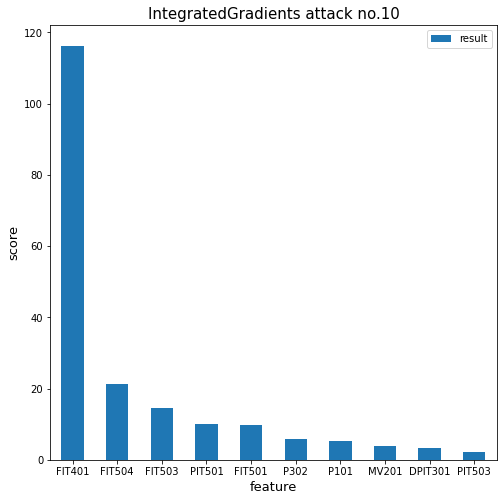

In [ ]:
ig_plot_9 = ig_result_9.sort_values(by = ["result"], ascending=False)[0:10]
ig_plot_9.plot.bar(rot=0,figsize=(8, 8))
plt.title("IntegratedGradients attack no.10",size=15)
plt.ylabel("score",size=13)
plt.xlabel("feature",size=13)

###ALE

In [ ]:
start = timeit.default_timer()
exp_ale_10 = ale.explain(sample_9.to_numpy())
end = timeit.default_timer()

In [ ]:
print(end-start)

5.506263303000196


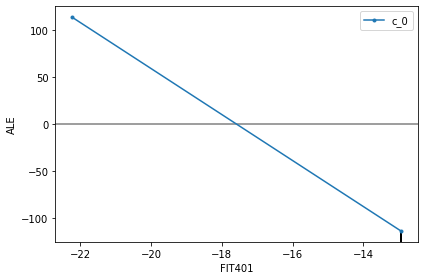

In [ ]:
from alibi.explainers import plot_ale
plot_ale(exp_ale_10, features = ['FIT401']);

In [ ]:
ale_result_10 = pd.DataFrame([np.mean(e) for e in exp_ale_10.ale_values], index = train_scale.columns, columns = ["result"])

In [ ]:
ale_result_10.sort_values(by=['result'], ascending=False)

result
FIT504   42.060760
FIT503   18.317585
FIT501   17.594320
PIT501   17.074490
FIT502    2.518911
PIT503    0.333040
FIT301    0.002078
AIT402    0.001334
DPIT301   0.000421
AIT203    0.000163
P502      0.000000
P501      0.000000
FIT601    0.000000
P302      0.000000
P601      0.000000
AIT501    0.000000
UV401     0.000000
P602      0.000000
P404      0.000000
P403      0.000000
P402      0.000000
P401      0.000000
FIT401    0.000000
AIT401    0.000000
P603      0.000000
P204      0.000000
P101      0.000000
MV201     0.000000
P201      0.000000
P202      0.000000
P203      0.000000
P301      0.000000
AIT201    0.000000
P102      0.000000
P205      0.000000
P206      0.000000
MV301     0.000000
MV302     0.000000
MV303     0.000000
MV101     0.000000
MV304     0.000000
LIT301   -0.000072
FIT201   -0.000073
AIT202   -0.000139
LIT101   -0.000142
FIT101   -0.000612
LIT401   -0.000711
AIT503   -0.001561
AIT502   -0.011439
PIT502   -0.358321
AIT504   -0.362392

## Attck no. 11


In [ ]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 11)].index.values

In [ ]:
sample_11 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [ ]:
shap_value_11 = shap_explainer.shap_values(X = sample_11, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
shap_result_11 = pd.DataFrame(np.mean(shap_value_11,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_11.sort_values(by = ["result"])

result
UV401     -18.007706
AIT402    -14.809542
AIT504    -14.754208
FIT601    -10.006126
P603        0.000000
P401        0.000000
P403        0.000000
P206        0.000000
P204        0.000000
P404        0.000000
P202        0.000000
P102        0.000000
P502        0.000000
P601        0.000000
P201        0.000000
P301        0.000000
AIT501      2.891536
AIT502      2.936434
P501        3.014441
MV303       4.222047
LIT401      4.288755
P205        4.334459
DPIT301     4.575619
P402        4.858865
AIT401      4.923340
P101        5.374287
MV101       5.473722
P302        5.618598
PIT502      5.990810
FIT101      6.092494
LIT301      6.128180
AIT202      6.178812
FIT301      6.358890
MV302       6.556108
P203        7.266324
P602        7.280558
FIT201      7.520912
AIT203      8.113536
LIT101      8.279126
MV201       8.710096
AIT503      9.649911
MV301       9.857577
AIT201     10.026458
MV304      12.408814
FIT502     41.921023
PIT503     99.542355
PIT501    447.380222
FIT401    514.740849
FIT501    800.610458
FIT503    861.475674
FIT504   1607.025983

In [ ]:
sp_obj_11 = submodular_pick.SubmodularPick(lime, sample_11.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -25.744397753433702
Prediction_local [93.9378237]
Right: 4534.783
Intercept -24.625716949148096
Prediction_local [86.69941682]
Right: 4540.3774
Intercept -18.5779457908702
Prediction_local [78.91889976]
Right: 3136.2686
Intercept -25.365446225857138
Prediction_local [90.87654087]
Right: 4511.4727
Intercept -25.103120462498097
Prediction_local [89.78359918]
Right: 4536.292
Intercept -25.17976895797824
Prediction_local [91.75228529]
Right: 4532.9307
Intercept -25.456117664732094
Prediction_local [90.89940815]
Right: 4521.4834
Intercept -26.044498821502817
Prediction_local [92.85909184]
Right: 4517.2236
Intercept -24.691455016525346
Prediction_local [89.59641672]
Right: 4503.9946
Intercept -25.1867786156196
Prediction_local [90.01787263]
Right: 4630.3423
Intercept -24.963568615632788
Prediction_local [91.2718338]
Right: 4517.4517
Intercept -25.31036006447529
Prediction_local [87.98006965]
Right: 4505.292
Intercept -26.382395105373487
Prediction_local [93.1941859]
Right: 4816.524

In [ ]:
sp_obj_11.sp_explanations[0].as_list()

[('AIT401 > 1.00', 10.320481657396677),
 ('FIT101 > 0.93', 7.966203729525013),
 ('0.31 < AIT201 <= 0.61', 6.856633814642995),
 ('0.00 < FIT601 <= 0.00', 6.011607144422535),
 ('LIT401 <= 0.31', 5.597401545241756),
 ('FIT501 <= 0.32', 5.513970354342357),
 ('FIT504 <= 0.43', 5.391450525753093),
 ('0.94 < DPIT301 <= 0.96', 5.36399552070207),
 ('AIT501 > 0.68', 5.29104253205842),
 ('AIT402 > 0.78', 5.2343213793960075),
 ('0.08 < LIT101 <= 0.34', 5.22371964577959),
 ('FIT301 > 0.94', 5.206920090531647),
 ('PIT502 <= 0.30', 5.193274342704277),
 ('FIT401 <= 0.35', 5.18111423196698),
 ('AIT503 > 0.53', 5.131843711675675),
 ('0.05 < AIT203 <= 0.08', 5.131046893794584),
 ('PIT501 <= 0.35', 4.846527328322991),
 ('FIT503 <= 0.34', 4.771977126565729),
 ('PIT503 <= 0.34', 4.68800466844108),
 ('FIT502 <= 0.41', 4.559389610231954)]

In [ ]:
ig_explanation_11 = ig.explain(sample_11.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_11))

In [ ]:
attributions_11 = ig_explanation_11.attributions

In [ ]:
ig_result_11 = pd.DataFrame(np.mean(attributions_11[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_11.sort_values(by = ["result"])

result
AIT402   -103.226202
AIT504    -84.504145
UV401     -82.856577
FIT301    -61.561031
P205      -39.967517
MV101     -35.598226
AIT501    -31.627846
FIT201    -30.318688
DPIT301   -28.091501
MV304     -25.163921
P203      -22.432551
FIT601    -19.756849
AIT401    -18.623031
MV301     -15.128901
P101      -12.776201
AIT503     -8.175644
PIT502     -2.008352
AIT203     -1.117462
LIT101     -0.754711
AIT202     -0.725591
LIT401     -0.329213
P601        0.000000
P404        0.000000
P403        0.000000
P401        0.000000
P502        0.000000
P603        0.000000
P204        0.000000
P201        0.000000
P301        0.000000
P102        0.000000
P202        0.000000
P206        0.000000
P602        0.046642
AIT201      0.307511
FIT101      3.659538
LIT301      5.357097
P402        7.748256
AIT502     18.490072
P302       22.295428
MV303      26.213564
P501       26.614670
MV302      45.032439
FIT502     61.931044
MV201     178.573798
PIT503    230.539194
PIT501    279.973432
FIT401    589.438341
FIT501    827.730413
FIT503   1207.876824
FIT504   1583.947574

In [ ]:
exp_ale_11 = ale.explain(sample_11.to_numpy())

In [ ]:
ale_result_11 = pd.DataFrame([np.mean(e) for e in exp_ale_11.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_11.sort_values(by=['result'], ascending=False)

result
FIT301     4.592839
DPIT301    1.611996
FIT201     1.378583
AIT402     1.170800
AIT501     0.724213
AIT502     0.072488
AIT203     0.052410
LIT301     0.017387
LIT401     0.013444
P601       0.000000
MV201      0.000000
MV101      0.000000
UV401      0.000000
P404       0.000000
P403       0.000000
P402       0.000000
P401       0.000000
P501       0.000000
P101       0.000000
P502       0.000000
P302       0.000000
P301       0.000000
MV304      0.000000
MV303      0.000000
MV302      0.000000
PIT502     0.000000
FIT504     0.000000
P102       0.000000
P602       0.000000
P206       0.000000
P205       0.000000
P204       0.000000
P203       0.000000
P202       0.000000
P201       0.000000
P603       0.000000
FIT101    -0.001241
AIT401    -0.001290
AIT201    -0.006667
LIT101    -0.006759
AIT202    -0.049956
AIT503    -0.056176
FIT502    -3.093544
AIT504    -3.111890
PIT503    -7.328333
PIT501   -12.189277
MV301    -13.308610
FIT501   -40.417426
FIT503   -49.691838
FIT401  -162.080478
FIT601  -348.927492

## Attck no. 20


In [ ]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 20)].index.values

In [ ]:
sample_20 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [ ]:
shap_value_20 = shap_explainer.shap_values(X = sample_20, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
shap_result_20 = pd.DataFrame(np.mean(shap_value_20,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_20.sort_values(by = ["result"])

result
PIT501    -20.157493
FIT501     -9.461681
AIT502     -8.485559
FIT201     -8.100664
FIT301     -4.609775
P101       -3.796012
DPIT301    -3.574367
FIT101     -0.857260
LIT101     -0.706681
LIT301     -0.375259
PIT502     -0.241896
AIT501     -0.168440
P602       -0.096405
LIT401     -0.049710
UV401       0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P501        0.000000
P502        0.000000
P601        0.000000
P401        0.000000
P301        0.000000
P603        0.000000
P102        0.000000
P206        0.000000
P204        0.000000
P202        0.000000
P201        0.000000
FIT601      0.009717
MV304       0.061060
MV301       0.064053
MV101       0.099155
MV303       0.104649
AIT203      0.153533
AIT401      0.376533
AIT202      0.384546
FIT504      0.532584
FIT502      0.586547
P302        1.314381
FIT401      1.578558
MV201       2.259012
MV302       2.801358
P205        3.072109
FIT503      3.267818
AIT503      3.695146
P203        4.882627
AIT201      7.014333
AIT402     11.892451
PIT503     19.790830
AIT504   4080.396745

In [ ]:
sp_obj_20 = submodular_pick.SubmodularPick(lime, sample_20.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -23.367572231058812
Prediction_local [80.86072595]
Right: 4079.9646
Intercept -23.140510696175514
Prediction_local [79.33326017]
Right: 4079.4668
Intercept -22.693786930626658
Prediction_local [77.70378224]
Right: 4087.9355
Intercept -22.74523659249124
Prediction_local [78.9572205]
Right: 4082.7808
Intercept -22.13992317897422
Prediction_local [74.86312842]
Right: 4082.6313
Intercept -22.418609804676976
Prediction_local [76.88497636]
Right: 4083.7397
Intercept -22.52522923212498
Prediction_local [79.8605064]
Right: 4082.9944
Intercept -22.12456895807351
Prediction_local [74.74680648]
Right: 4079.9646
Intercept -23.17098025159832
Prediction_local [80.74360782]
Right: 4078.6694
Intercept -22.41449376740768
Prediction_local [79.52330667]
Right: 4082.8616
Intercept -23.08950751836578
Prediction_local [79.8042004]
Right: 4092.2583
Intercept -23.000027379589834
Prediction_local [81.68690457]
Right: 4076.5288
Intercept -22.641141239387856
Prediction_local [78.05304359]
Right: 4078.4

In [ ]:
sp_obj_20.sp_explanations[0].as_list()

[('AIT401 > 1.00', 9.60903742531017),
 ('FIT101 > 0.93', 7.433622423620259),
 ('0.31 < LIT401 <= 0.52', 5.642464580055041),
 ('0.00 < FIT601 <= 0.00', 5.572093559116874),
 ('0.94 < FIT301 <= 0.94', 4.852532320283052),
 ('PIT502 > 0.43', 4.8110177151480364),
 ('FIT401 > 0.63', 4.791175801259542),
 ('0.94 < DPIT301 <= 0.96', 4.754488095334929),
 ('0.08 < AIT202 <= 0.16', 4.735356582650391),
 ('PIT503 <= 0.34', 4.674917196934465),
 ('0.54 < LIT301 <= 0.71', 4.64370499405094),
 ('AIT502 <= 0.16', 4.58471569313899),
 ('PIT501 <= 0.35', 4.583562721627247),
 ('0.08 < AIT203 <= 0.10', 4.575598143010509),
 ('AIT504 > 0.57', 4.5176861074120716),
 ('AIT503 <= 0.42', 4.429956450010729),
 ('LIT101 <= 0.08', 4.383571445187851),
 ('FIT503 <= 0.34', 4.132610236511938),
 ('FIT501 > 0.62', 4.095694319102243),
 ('FIT504 <= 0.43', 4.016201049873335)]

In [ ]:
ig_explanation_20 = ig.explain(sample_20.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_20))

In [ ]:
attributions_20 = ig_explanation_20.attributions

In [ ]:
ig_result_20 = pd.DataFrame(np.mean(attributions_20[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_20.sort_values(by = ["result"])

result
FIT501    -42.079240
FIT201    -36.436304
FIT301    -34.713679
DPIT301   -33.831896
PIT503    -24.002937
P101      -21.349467
AIT503     -9.180193
MV301      -9.173869
FIT503     -9.062484
FIT101     -9.052814
MV101      -4.837390
LIT401     -4.399495
FIT504     -4.144087
LIT301     -3.528215
PIT502     -3.129768
MV304      -2.157037
AIT203     -0.621525
AIT402     -0.314423
AIT202     -0.279380
MV303      -0.241810
FIT601     -0.000835
P402        0.000000
P403        0.000000
P502        0.000000
UV401       0.000000
P401        0.000000
P501        0.000000
P404        0.000000
P601        0.000000
P603        0.000000
P602        0.000000
P102        0.000000
P201        0.000000
P202        0.000000
P206        0.000000
P204        0.000000
P301        0.000000
AIT501      0.363249
LIT101      0.608514
AIT201      1.051511
FIT502      2.756078
AIT502      2.894798
FIT401      8.312981
AIT401      8.320275
P302       14.052907
P205       14.419098
P203       25.485086
MV201      27.627717
PIT501     35.280520
MV302      52.568225
AIT504   4139.434218

In [ ]:
exp_ale_20 = ale.explain(sample_20.to_numpy())
ale_result_20 = pd.DataFrame([np.mean(e) for e in exp_ale_20.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_20.sort_values(by=['result'], ascending=False)

result
PIT501   0.174695
AIT502   0.042288
FIT502   0.041023
PIT502   0.035395
FIT401   0.005253
AIT202   0.000961
LIT101   0.000913
AIT203   0.000069
P401     0.000000
P402     0.000000
P403     0.000000
P404     0.000000
UV401    0.000000
AIT401   0.000000
AIT504   0.000000
P301     0.000000
P501     0.000000
P502     0.000000
FIT601   0.000000
P601     0.000000
P602     0.000000
P302     0.000000
P603     0.000000
MV304    0.000000
P205     0.000000
MV101    0.000000
P101     0.000000
P102     0.000000
MV201    0.000000
P201     0.000000
P202     0.000000
MV303    0.000000
P204     0.000000
P203     0.000000
P206     0.000000
MV302    0.000000
MV301    0.000000
LIT401  -0.004009
LIT301  -0.004823
FIT201  -0.005583
FIT301  -0.006204
FIT101  -0.006527
AIT501  -0.008076
DPIT301 -0.013616
AIT402  -0.069303
AIT201  -0.073170
FIT504  -0.092867
PIT503  -0.183737
FIT503  -0.218994
FIT501  -0.326825
AIT503  -0.751194

## Attck no. 22


In [ ]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 22)].index.values

In [ ]:
sample_22 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [ ]:
shap_value_22 = shap_explainer.shap_values(X = sample_22, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
shap_result_22 = pd.DataFrame(np.mean(shap_value_22,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_22.sort_values(by = ["result"])

result
AIT402    -10.830859
AIT504     -3.794541
UV401      -1.354684
AIT501     -0.045743
P603        0.000000
P403        0.000000
P404        0.000000
P301        0.000000
P502        0.000000
P401        0.000000
P204        0.000000
P206        0.000000
P402        0.000000
P201        0.000000
P601        0.000000
P102        0.000000
P202        0.000000
P203        0.871550
P101        1.496518
FIT201      1.829638
MV301       2.107621
PIT502      2.118060
P205        2.448257
MV302       2.787421
AIT502      2.891715
AIT201      3.235022
FIT601      3.329634
AIT202      3.521654
LIT101      3.636628
FIT301      3.647278
MV304       4.442560
FIT101      5.650836
MV101       5.700243
DPIT301     5.720242
AIT401      5.956097
P602        5.969124
P302        6.244423
AIT203      6.765864
MV303       7.031779
MV201       7.040840
LIT401      7.719069
LIT301      7.843932
AIT503      7.883062
P501       13.186519
FIT502     22.329205
FIT401     34.773124
PIT503    155.927641
PIT501    305.451229
FIT501    834.048456
FIT503    859.944791
FIT504   1566.787185

In [ ]:
sp_obj_22 = submodular_pick.SubmodularPick(lime, sample_22.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -20.846046527305585
Prediction_local [64.18534494]
Right: 3867.4365
Intercept -21.392084053936223
Prediction_local [68.07176581]
Right: 4041.2612
Intercept -21.74877853274082
Prediction_local [67.02538775]
Right: 3967.207
Intercept -20.15541250692742
Prediction_local [62.00351584]
Right: 3799.525
Intercept -20.93986305646542
Prediction_local [64.57476213]
Right: 3909.829
Intercept -21.56822298864767
Prediction_local [67.3514499]
Right: 3988.0908
Intercept -22.417329098159442
Prediction_local [67.96058388]
Right: 4048.8308
Intercept -21.20549221314283
Prediction_local [65.89127476]
Right: 3877.7043
Intercept -20.888187126046613
Prediction_local [64.91181523]
Right: 3830.8003
Intercept -21.666729195442187
Prediction_local [66.71732046]
Right: 3930.3762
Intercept -20.882244324478847
Prediction_local [65.46432508]
Right: 3893.7056
Intercept -23.508355286233567
Prediction_local [72.17638127]
Right: 4201.4834
Intercept -20.57766168362034
Prediction_local [64.523777]
Right: 3860.542

In [ ]:
sp_obj_22.sp_explanations[0].as_list()

[('AIT503 <= 0.42', 4.813803741788395),
 ('0.08 < AIT203 <= 0.10', 4.559594446861509),
 ('0.12 < FIT301 <= 0.94', 4.445949393039566),
 ('PIT501 <= 0.35', 4.429643315875652),
 ('AIT402 > 0.78', 4.4129725443866565),
 ('0.16 < AIT502 <= 0.50', 4.3539591488119065),
 ('FIT502 <= 0.41', 4.352899629997141),
 ('FIT503 <= 0.34', 4.303771522426142),
 ('FIT504 <= 0.43', 4.302666891187139),
 ('FIT401 <= 0.35', 4.29165805085524),
 ('PIT502 <= 0.30', 4.245265728915043),
 ('FIT501 <= 0.32', 4.182941083613876),
 ('FIT201 > 0.98', 4.140545130708338),
 ('PIT503 <= 0.34', 4.134572273548969),
 ('DPIT301 > 0.96', 4.113174761363114),
 ('LIT401 <= 0.31', 4.097824549802232),
 ('AIT501 > 0.68', 4.078475823215358),
 ('LIT301 <= 0.36', 4.0693346998362),
 ('AIT202 > 0.16', 4.054944381363582),
 ('AIT504 > 0.57', 4.023186402704884)]

In [ ]:
ig_explanation_22 = ig.explain(sample_22.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_22))

In [ ]:
attributions_22 = ig_explanation_22.attributions

In [ ]:
ig_result_22 = pd.DataFrame(np.mean(attributions_22[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_22.sort_values(by = ["result"])

result
AIT402    -93.540542
AIT504    -75.561392
UV401     -72.034172
FIT301    -68.299868
AIT501    -41.031511
P205      -38.474765
P203      -37.670595
DPIT301   -32.050841
FIT201    -28.193202
MV304     -25.369609
AIT401    -25.063019
MV301     -17.312444
MV101     -17.214545
AIT503     -8.443672
P101       -4.349074
LIT401     -3.796794
LIT101     -3.733962
AIT202     -2.373286
AIT203     -1.610408
AIT201     -1.247864
FIT601      0.000000
P601        0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P401        0.000000
P502        0.000000
FIT101      0.000000
P602        0.000000
P102        0.000000
P201        0.000000
P202        0.000000
P204        0.000000
P206        0.000000
P603        0.000000
P301        0.000000
PIT502      0.497622
LIT301      0.973405
AIT502      3.686338
MV303      22.198628
P302       25.613883
P501       40.252420
MV302      43.689745
FIT502     50.591254
FIT401     74.975723
MV201     169.422184
PIT503    195.196869
PIT501    240.064977
FIT501    847.140069
FIT503   1143.842428
FIT504   1630.519364

In [ ]:
exp_ale_22 = ale.explain(sample_22.to_numpy())
ale_result_22 = pd.DataFrame([np.mean(e) for e in exp_ale_22.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_22.sort_values(by=['result'], ascending=False)

result
AIT502   11.983250
AIT501    0.592446
AIT402    0.389295
LIT301    0.018581
AIT201    0.015519
P302      0.000000
P401      0.000000
P402      0.000000
P403      0.000000
P404      0.000000
UV401     0.000000
FIT101    0.000000
MV304     0.000000
FIT504    0.000000
P501      0.000000
P502      0.000000
PIT502    0.000000
FIT601    0.000000
P601      0.000000
P602      0.000000
P301      0.000000
AIT401    0.000000
MV303     0.000000
P204      0.000000
MV101     0.000000
P101      0.000000
P102      0.000000
MV201     0.000000
MV302     0.000000
P201      0.000000
P202      0.000000
P203      0.000000
P603      0.000000
P205      0.000000
P206      0.000000
MV301     0.000000
DPIT301  -0.003556
FIT201   -0.005934
AIT203   -0.010127
FIT301   -0.010985
AIT202   -0.014425
LIT401   -0.018509
LIT101   -0.019069
AIT503   -0.108873
FIT401   -1.778301
FIT502   -2.073071
AIT504   -2.746274
PIT503   -7.916518
PIT501  -14.508526
FIT501  -39.981265
FIT503  -49.691325

## Attck no. 28


In [ ]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 28)].index.values

In [ ]:
sample_28 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [ ]:
shap_value_28 = shap_explainer.shap_values(X = sample_28, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
shap_result_28 = pd.DataFrame(np.mean(shap_value_28,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_28.sort_values(by = ["result"])

result
AIT402    -23.283503
P603        0.000000
P301        0.000000
P206        0.000000
P401        0.000000
P204        0.000000
P403        0.000000
P202        0.000000
P201        0.000000
P102        0.000000
P502        0.000000
P601        0.000000
P404        0.000000
AIT504      0.078328
MV201       1.072947
UV401       2.724229
P302        3.923236
MV304       5.931554
AIT202      7.091694
P101       10.316315
MV303      11.175914
FIT101     12.515637
PIT502     14.483808
FIT601     16.986563
LIT301     17.684653
AIT203     18.586118
P602       19.666571
AIT502     20.571718
AIT401     21.019478
LIT401     21.251601
AIT201     21.634117
MV302      22.530026
FIT201     24.010381
LIT101     24.147152
AIT503     24.545202
DPIT301    25.458133
MV301      28.047969
P501       33.789369
MV101      37.043167
P205       42.918431
P203       48.786735
AIT501     77.041111
FIT301     79.477571
P402      356.032593
FIT502    526.021230
FIT401    866.985768
PIT503   1780.906224
FIT504   3523.251863
PIT501   3561.543327
FIT503   3890.129474
FIT501   8342.097837

In [ ]:
sp_obj_28 = submodular_pick.SubmodularPick(lime, sample_28.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -133.9628869509804
Prediction_local [562.00570669]
Right: 23470.332
Intercept -135.28478255854648
Prediction_local [558.72509931]
Right: 23735.674
Intercept -135.32339605291924
Prediction_local [588.59410193]
Right: 23527.76
Intercept -134.40691443808902
Prediction_local [587.26597144]
Right: 23467.963
Intercept -135.07884739112882
Prediction_local [570.50554015]
Right: 23477.05
Intercept -130.97839301647113
Prediction_local [580.55253392]
Right: 23478.45
Intercept -132.46811503568549
Prediction_local [589.09384625]
Right: 23490.191
Intercept -133.20741198384005
Prediction_local [528.04629378]
Right: 23483.695
Intercept -134.01350084910857
Prediction_local [582.17722738]
Right: 23476.488
Intercept -133.33917904695468
Prediction_local [574.7956008]
Right: 23543.898
Intercept -131.7088925073204
Prediction_local [532.32221162]
Right: 23499.162
Intercept -139.01270946145408
Prediction_local [593.69216471]
Right: 23788.027
Intercept -137.55464594449674
Prediction_local [609.879230

In [ ]:
sp_obj_28.sp_explanations[0].as_list()

[('MV304 > 0.50', 178.47572802295963),
 ('AIT401 > 1.00', 55.79263822451385),
 ('0.49 < AIT503 <= 0.53', 30.755103169097897),
 ('AIT504 > 0.57', 30.370023942534775),
 ('PIT503 <= 0.34', 29.804954513433113),
 ('PIT501 <= 0.35', 29.204547418861758),
 ('AIT402 > 0.78', 28.369790366285823),
 ('DPIT301 <= 0.12', 28.10159916114987),
 ('FIT502 <= 0.41', 27.934038611668413),
 ('FIT503 <= 0.34', 27.41812390909339),
 ('AIT502 > 0.78', 27.353541976020313),
 ('LIT301 > 0.71', 27.134184252475166),
 ('LIT401 <= 0.31', 26.9731797238597),
 ('AIT202 > 0.16', 26.69495909854271),
 ('PIT502 <= 0.30', 26.026091858850148),
 ('FIT301 <= 0.12', 25.753743861177863),
 ('FIT401 <= 0.35', 24.722628522733885),
 ('FIT501 <= 0.32', 24.079657104691332),
 ('FIT201 <= 0.01', 23.876508937239528),
 ('LIT101 > 0.64', 23.583816748681993)]

In [ ]:
ig_explanation_28 = ig.explain(sample_28.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_28))

In [ ]:
attributions_28 = ig_explanation_28.attributions

In [ ]:
ig_result_28 = pd.DataFrame(np.mean(attributions_28[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_28.sort_values(by = ["result"])

result
AIT402   -577.420649
AIT504   -217.738956
UV401    -135.397152
MV304    -129.897155
AIT201    -59.364767
MV101     -47.499441
MV301     -46.827200
AIT503    -31.869028
AIT401    -30.656958
AIT202    -23.417674
LIT101    -21.388829
DPIT301   -13.556997
LIT301     -4.720976
AIT203     -4.275694
FIT601     -0.001452
P601        0.000000
P404        0.000000
P602        0.000000
P301        0.000000
P502        0.000000
P302        0.000000
P401        0.000000
P403        0.000000
FIT101      0.000000
P603        0.000000
FIT301      0.000000
P206        0.000000
P101        0.000000
P102        0.000000
P205        0.000000
P204        0.000000
P203        0.000000
P202        0.000000
FIT201      0.000000
P201        0.000000
PIT502      7.092707
MV302      21.750012
LIT401     22.262589
MV303      67.186492
AIT502     78.650393
P501      107.845551
AIT501    146.082574
MV201     226.120753
P402      563.099872
FIT502    565.190209
FIT401    667.790072
PIT503   2488.005117
PIT501   2672.166446
FIT504   3431.477805
FIT503   4952.653894
FIT501   8841.834708

In [ ]:
exp_ale_28 = ale.explain(sample_28.to_numpy())
ale_result_28 = pd.DataFrame([np.mean(e) for e in exp_ale_28.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_28.sort_values(by=['result'], ascending=False)

result
AIT402   16.597069
FIT503    2.226889
PIT503    0.220969
AIT201    0.167794
FIT502    0.115959
DPIT301   0.089540
AIT203    0.069698
AIT202    0.001668
LIT301    0.000292
UV401     0.000000
FIT401    0.000000
P401      0.000000
P402      0.000000
P403      0.000000
P404      0.000000
FIT101    0.000000
P302      0.000000
P501      0.000000
P502      0.000000
PIT502    0.000000
FIT601    0.000000
P601      0.000000
P602      0.000000
FIT504    0.000000
P603      0.000000
MV101     0.000000
P101      0.000000
P202      0.000000
P203      0.000000
P204      0.000000
P205      0.000000
P301      0.000000
FIT201    0.000000
P102      0.000000
P201      0.000000
MV201     0.000000
P206      0.000000
FIT301    0.000000
MV301     0.000000
MV302     0.000000
MV303     0.000000
MV304     0.000000
AIT401   -0.000811
LIT401   -0.001031
LIT101   -0.001138
AIT503   -0.015529
AIT502   -0.307760
PIT501   -0.317249
AIT504   -0.429659
FIT501   -1.383072
AIT501   -2.487195

## Attck no. 30

In [ ]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 30)].index.values

In [ ]:
sample_30 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [ ]:
shap_value_30 = shap_explainer.shap_values(X = sample_30, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
shap_result_30 = pd.DataFrame(np.mean(shap_value_30,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_30.sort_values(by = ["result"])

result
PIT501   -0.103583
MV101    -0.030331
P603      0.000000
P301      0.000000
P402      0.000000
P501      0.000000
P403      0.000000
P404      0.000000
FIT301    0.000000
P206      0.000000
P502      0.000000
P204      0.000000
P203      0.000000
P202      0.000000
P201      0.000000
UV401     0.000000
AIT501    0.000000
FIT503    0.000000
P601      0.000000
P401      0.000000
AIT203    0.000017
FIT504    0.001254
AIT202    0.002054
DPIT301   0.002205
MV304     0.002654
FIT601    0.003852
LIT301    0.003881
FIT502    0.004478
P302      0.005108
FIT201    0.005519
FIT401    0.006317
MV303     0.006874
MV301     0.008906
MV201     0.009796
LIT401    0.010790
AIT503    0.011957
P602      0.013941
P101      0.014178
AIT401    0.014689
MV302     0.017352
FIT501    0.019758
P205      0.024366
PIT502    0.038850
AIT402    0.042507
LIT101    0.051445
AIT502    0.075329
PIT503    0.167627
FIT101    0.519410
AIT504    2.432318
AIT201    5.348689
P102     29.018233

In [ ]:
sp_obj_30 = submodular_pick.SubmodularPick(lime, sample_30.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept 0.43881389795547554
Prediction_local [19.29192296]
Right: 38.156597
Intercept 0.44967595055349463
Prediction_local [19.1538718]
Right: 37.784393
Intercept 0.3929956832558924
Prediction_local [19.17997366]
Right: 37.904503
Intercept 0.4171645701550133
Prediction_local [19.23909377]
Right: 37.96127
Intercept 0.45452417405541257
Prediction_local [19.25219479]
Right: 38.01471
Intercept 0.22580153036137993
Prediction_local [19.12810806]
Right: 37.803825
Intercept 0.4890131551322592
Prediction_local [19.2176302]
Right: 38.034477
Intercept 0.30755198734101097
Prediction_local [19.13105679]
Right: 37.79635
Intercept 0.40545664354675337
Prediction_local [19.11728844]
Right: 37.79578
Intercept 0.38782288487379835
Prediction_local [19.13169212]
Right: 37.867104
Intercept 0.4489053173538437
Prediction_local [19.06599115]
Right: 37.64729
Intercept 0.31119258238844916
Prediction_local [19.1950486]
Right: 37.95069
Intercept 0.3676451670843901
Prediction_local [19.18687802]
Right: 37.867104


In [ ]:
sp_obj_30.sp_explanations[0].as_list()

[('P102 > 0.00', 18.514238941242727),
 ('MV301 <= 0.50', -0.12029320577033613),
 ('P602 <= 0.00', -0.11764646563740695),
 ('PIT503 <= 0.34', 0.10341266847346646),
 ('0.00 < P101 <= 1.00', -0.10216776605682885),
 ('0.00 < P302 <= 1.00', 0.08351168837013002),
 ('MV101 <= 0.50', 0.07797815622199832),
 ('FIT504 <= 0.43', 0.06958035529476861),
 ('AIT402 <= 0.20', 0.05952816906719444),
 ('FIT503 <= 0.34', 0.05791592487791108),
 ('AIT504 > 0.57', 0.057815810645805536),
 ('0.00 < P203 <= 1.00', 0.04989319592868822),
 ('0.50 < MV201 <= 1.00', 0.046480197832039834),
 ('MV304 <= 0.50', 0.04442184046590219),
 ('MV303 <= 0.50', -0.040763698207609),
 ('0.50 < MV302 <= 1.00', 0.036725372300078496),
 ('FIT601 <= 0.00', -0.02896039933333092),
 ('DPIT301 > 0.96', -0.013946450303737984),
 ('AIT501 <= 0.40', -0.011146937943195065),
 ('AIT502 <= 0.16', -0.0039062528601625885)]

In [ ]:
ig_explanation_30 = ig.explain(sample_30.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_30))

In [ ]:
attributions_30 = ig_explanation_30.attributions

In [ ]:
ig_result_30 = pd.DataFrame(np.mean(attributions_30[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_30.sort_values(by = ["result"])

result
FIT301   -1.432775
P203     -0.756192
DPIT301  -0.565590
MV201    -0.551000
AIT503   -0.455470
PIT503   -0.382328
LIT401   -0.256679
AIT202   -0.218405
MV303    -0.199657
PIT502   -0.140333
FIT401   -0.090062
MV304    -0.027097
P302     -0.010795
AIT203   -0.003427
P404      0.000000
P403      0.000000
P402      0.000000
UV401     0.000000
P501      0.000000
P401      0.000000
P502      0.000000
FIT601    0.000000
P601      0.000000
P602      0.000000
FIT101    0.000000
P603      0.000000
P206      0.000000
P301      0.000000
P204      0.000000
P202      0.000000
P201      0.000000
LIT301    0.038756
AIT501    0.055660
AIT502    0.071895
AIT402    0.091108
FIT201    0.095180
FIT502    0.148358
FIT501    0.185097
FIT503    0.289911
LIT101    0.358759
FIT504    0.396281
P101      0.504361
P205      0.552155
MV301     0.570772
MV101     0.589626
PIT501    0.837339
AIT401    1.143262
MV302     1.843416
AIT504    3.394057
AIT201    6.254440
P102     22.401662

In [ ]:
exp_ale_30 = ale.explain(sample_30.to_numpy())
ale_result_30 = pd.DataFrame([np.mean(e) for e in exp_ale_30.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_30.sort_values(by=['result'], ascending=False)

result
FIT503   0.037290
FIT504   0.032726
AIT201   0.007853
PIT501   0.006523
AIT503   0.001895
AIT501   0.001510
LIT401   0.001145
FIT502   0.000801
FIT501   0.000668
AIT202   0.000402
AIT401   0.000106
FIT401   0.000016
P501     0.000000
P302     0.000000
P502     0.000000
FIT601   0.000000
P601     0.000000
UV401    0.000000
P404     0.000000
P403     0.000000
P402     0.000000
P401     0.000000
P602     0.000000
LIT101   0.000000
FIT101   0.000000
P301     0.000000
P205     0.000000
MV101    0.000000
P101     0.000000
P102     0.000000
MV201    0.000000
P201     0.000000
P202     0.000000
P203     0.000000
P204     0.000000
P206     0.000000
MV301    0.000000
MV302    0.000000
MV303    0.000000
MV304    0.000000
P603     0.000000
FIT201  -0.000007
FIT301  -0.000031
DPIT301 -0.000075
AIT203  -0.000281
AIT502  -0.000349
AIT402  -0.000619
LIT301  -0.001496
PIT503  -0.003135
AIT504  -0.006102
PIT502  -0.021782

## Attck no. 37


In [ ]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 37)].index.values

In [ ]:
sample_37 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [ ]:
shap_value_37 = shap_explainer.shap_values(X = sample_37, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
shap_result_37 = pd.DataFrame(np.mean(shap_value_37,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_37.sort_values(by = ["result"])

result
AIT504    -14.020398
P603        0.000000
P403        0.000000
P404        0.000000
P301        0.000000
UV401       0.000000
P401        0.000000
P204        0.000000
P202        0.000000
P201        0.000000
P206        0.000000
P501        0.000000
P601        0.000000
P102        0.000000
P402        0.000000
P502        0.000000
LIT301      1.539021
AIT502      1.752810
LIT401      2.765254
P602        3.727126
FIT601      3.967739
AIT203      4.067175
MV304       4.354565
MV301       4.440169
MV303       4.554898
PIT502      4.700309
P302        4.931554
MV201       5.019737
MV302       5.390688
DPIT301     5.596921
AIT201      5.808328
FIT101      5.968847
AIT401      6.092316
AIT202      6.286650
FIT201      6.409959
AIT503      6.988289
P101        6.999000
P203        7.886270
LIT101      8.035586
FIT301      8.336230
MV101       9.407691
P205       10.230450
AIT501     11.002050
FIT502     15.168632
AIT402     19.694937
FIT401     45.978957
PIT503    160.817034
PIT501    240.818863
FIT501    769.942190
FIT503    921.795624
FIT504   1536.896581

In [ ]:
sp_obj_37 = submodular_pick.SubmodularPick(lime, sample_37.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -21.05589760277053
Prediction_local [63.39186018]
Right: 3792.165
Intercept -20.09185306091352
Prediction_local [61.69067121]
Right: 3840.3284
Intercept -21.54610315367379
Prediction_local [68.55043227]
Right: 3945.6177
Intercept -21.48484081183334
Prediction_local [64.81052648]
Right: 3880.462
Intercept -20.94884046859065
Prediction_local [63.9690274]
Right: 3862.5151
Intercept -20.79607682835923
Prediction_local [63.37777377]
Right: 3840.3284
Intercept -19.62564846085301
Prediction_local [62.51343206]
Right: 3772.9717
Intercept -21.96966342324703
Prediction_local [67.10483364]
Right: 3888.1875
Intercept -20.51497440408119
Prediction_local [61.77556336]
Right: 3905.859
Intercept -0.1990745007481939
Prediction_local [2.22879132]
Right: 117.11483
Intercept -22.084503023886043
Prediction_local [68.79429361]
Right: 3903.224
Intercept -20.80776182950144
Prediction_local [63.63899635]
Right: 3849.8074
Intercept -21.06378005248479
Prediction_local [65.64883392]
Right: 3966.2026
Int

In [ ]:
sp_obj_37.sp_explanations[0].as_list()

[('AIT203 <= 0.05', 4.706767482232571),
 ('FIT201 > 0.98', 4.627373388554247),
 ('0.12 < FIT301 <= 0.94', 4.599527425045733),
 ('PIT502 <= 0.30', 4.537437249103033),
 ('AIT502 <= 0.16', 4.4237230543654915),
 ('PIT501 <= 0.35', 4.385296597760398),
 ('LIT101 > 0.64', 4.349915232441417),
 ('AIT504 > 0.57', 4.302149637019135),
 ('FIT503 <= 0.34', 4.277704857731538),
 ('PIT503 <= 0.34', 4.170970001451837),
 ('FIT501 <= 0.32', 4.143305572004813),
 ('FIT401 <= 0.35', 4.063137042437059),
 ('FIT504 <= 0.43', 4.045448347387304),
 ('LIT301 <= 0.36', 4.004661834178635),
 ('AIT202 > 0.16', 3.944038362896123),
 ('AIT402 <= 0.20', 3.9363861293137705),
 ('AIT503 <= 0.42', 3.9031038914847076),
 ('FIT502 > 0.56', 3.902413923790659),
 ('DPIT301 > 0.96', 3.875846080726575),
 ('LIT401 > 0.65', 3.700241039087683)]

In [ ]:
ig_explanation_37 = ig.explain(sample_37.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_37))

In [ ]:
attributions_37 = ig_explanation_37.attributions

In [ ]:
ig_result_37 = pd.DataFrame(np.mean(attributions_37[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_37.sort_values(by = ["result"])

result
AIT504   -104.277499
FIT301    -55.619977
DPIT301   -27.803948
AIT401    -24.973393
MV101     -23.966125
MV304     -22.258856
P205      -20.941827
FIT201    -17.330349
P203      -15.933411
MV301     -14.771600
LIT401     -7.246524
AIT202     -7.226532
AIT503     -7.099736
LIT101     -5.400656
AIT502     -3.327929
AIT201     -2.672687
P101       -2.210651
FIT502     -1.973650
P401        0.000000
P501        0.000000
P502        0.000000
FIT601      0.000000
UV401       0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P601        0.000000
P603        0.000000
P202        0.000000
P602        0.000000
P102        0.000000
P301        0.000000
P201        0.000000
P204        0.000000
P206        0.000000
PIT502      0.400031
FIT101      0.950794
AIT203      1.040622
LIT301      2.263837
AIT402     14.986108
AIT501     15.086173
P302       19.147684
MV303      22.556957
MV302      39.575368
FIT401     77.269765
MV201     126.603427
PIT503    176.912443
PIT501    181.323425
FIT501    757.854110
FIT503   1116.518945
FIT504   1662.879609

In [ ]:
exp_ale_37 = ale.explain(sample_37.to_numpy())
ale_result_37 = pd.DataFrame([np.mean(e) for e in exp_ale_37.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_37.sort_values(by=['result'], ascending=False)

result
FIT502   25.981287
FIT101    2.920329
AIT502    0.176345
LIT301    0.162552
LIT101    0.023969
LIT401    0.004071
P601      0.000000
FIT601    0.000000
P302      0.000000
P401      0.000000
P402      0.000000
P403      0.000000
P404      0.000000
UV401     0.000000
MV304     0.000000
P602      0.000000
FIT504    0.000000
P501      0.000000
P502      0.000000
PIT502    0.000000
P301      0.000000
AIT401    0.000000
MV303     0.000000
P205      0.000000
P101      0.000000
P102      0.000000
P201      0.000000
P202      0.000000
P203      0.000000
P204      0.000000
P603      0.000000
P206      0.000000
MV301     0.000000
AIT201   -0.019164
AIT202   -0.019893
AIT203   -0.059006
AIT504   -0.262694
AIT402   -0.318815
AIT503   -0.325197
DPIT301  -0.338966
AIT501   -0.714660
FIT301   -1.740244
MV101    -4.426969
FIT401   -4.466937
PIT501   -8.951720
FIT201   -9.730118
PIT503   -9.830069
MV201    -9.926987
MV302   -14.303083
FIT501  -41.538771
FIT503  -73.814987

## Attck no. 39


In [ ]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 39)].index.values

In [ ]:
sample_39 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [ ]:
shap_value_39 = shap_explainer.shap_values(X = sample_39, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
shap_result_39 = pd.DataFrame(np.mean(shap_value_39,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_39.sort_values(by = ["result"])

result
AIT504   -11.616539
PIT503    -2.989780
AIT503    -1.296212
P203      -0.113194
AIT202    -0.058495
MV302     -0.040660
FIT301    -0.009585
FIT101    -0.000043
P502       0.000000
P404       0.000000
P403       0.000000
P402       0.000000
P601       0.000000
P401       0.000000
P301       0.000000
P501       0.000000
UV401      0.000000
P603       0.000000
P204       0.000000
P206       0.000000
P102       0.000000
P202       0.000000
MV101      0.001081
FIT502     0.014955
FIT601     0.028014
P205       0.032979
AIT203     0.037047
LIT401     0.041272
FIT503     0.049768
P602       0.054169
MV301      0.055123
MV201      0.057187
FIT504     0.075960
MV304      0.076971
FIT501     0.078987
AIT401     0.086770
AIT402     0.092315
MV303      0.098590
PIT502     0.112061
FIT201     0.135637
LIT101     0.172995
LIT301     0.208593
P302       0.448581
DPIT301    0.464311
P101       0.814264
AIT502     2.888320
AIT501     3.511209
PIT501     9.232193
AIT201    16.213856
P201      19.770751
FIT401   155.922496

In [ ]:
sp_obj_39 = submodular_pick.SubmodularPick(lime, sample_39.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept 0.21116525870301786
Prediction_local [98.03434219]
Right: 195.10135
Intercept 0.17124288203956145
Prediction_local [98.11488605]
Right: 195.12935
Intercept 0.04988534371178904
Prediction_local [98.50320458]
Right: 195.89172
Intercept 0.0961301591526299
Prediction_local [97.76665973]
Right: 194.31084
Intercept 0.1277235042399995
Prediction_local [97.27376013]
Right: 193.24013
Intercept 0.1289135757353966
Prediction_local [97.49093632]
Right: 193.91727
Intercept 0.06533149070233896
Prediction_local [96.97562258]
Right: 192.8465
Intercept 0.03413347771975547
Prediction_local [96.99136187]
Right: 192.8465
Intercept 0.0063430670110808385
Prediction_local [98.16157316]
Right: 195.06245
Intercept 0.04222290394737915
Prediction_local [97.36881611]
Right: 193.55412
Intercept 0.16729559981112524
Prediction_local [98.36771387]
Right: 195.72769
Intercept 0.11101959924405014
Prediction_local [97.9493418]
Right: 194.82097
Intercept 0.0900290381682391
Prediction_local [97.08672548]
Right: 1

In [ ]:
sp_obj_39.sp_explanations[0].as_list()

[('P201 > 0.00', 96.58751317075372),
 ('P602 <= 0.00', -0.1797390444879581),
 ('PIT503 <= 0.34', 0.16565514314157515),
 ('AIT504 > 0.57', 0.13012639178341862),
 ('LIT101 <= 0.08', 0.12342876723057353),
 ('AIT503 <= 0.42', 0.12240287815754843),
 ('FIT503 <= 0.34', 0.12005770712435583),
 ('AIT402 <= 0.20', 0.11988568356314787),
 ('0.41 < FIT501 <= 0.62', 0.10227748763262856),
 ('LIT401 <= 0.31', 0.09327260613695344),
 ('0.00 < P302 <= 1.00', 0.08653090676277303),
 ('DPIT301 > 0.96', 0.077996862048889),
 ('AIT502 <= 0.16', 0.0745316578008916),
 ('FIT201 > 0.98', 0.063311580877921),
 ('0.00 < P203 <= 1.00', 0.06090022821127911),
 ('MV301 <= 0.50', -0.05104096276511),
 ('0.00 < P101 <= 1.00', -0.04143593911906136),
 ('MV303 <= 0.50', -0.03785232987331737),
 ('FIT601 <= 0.00', -0.00523278138352734),
 ('0.50 < MV101 <= 1.00', -0.0009056367752220981)]

In [ ]:
ig_explanation_39 = ig.explain(sample_39.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_39))

In [ ]:
attributions_39 = ig_explanation_39.attributions

In [ ]:
ig_result_39 = pd.DataFrame(np.mean(attributions_39[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_39.sort_values(by = ["result"])

result
AIT504   -17.616441
MV302     -8.438230
FIT301    -5.354292
PIT501    -4.727825
P203      -3.071595
FIT504    -2.431734
FIT101    -2.190271
MV304     -1.975930
FIT502    -1.647498
AIT503    -0.983034
FIT501    -0.799158
AIT202    -0.701342
MV201     -0.516923
AIT401    -0.204149
LIT301    -0.158514
PIT502    -0.148843
MV101     -0.092451
LIT101    -0.043534
LIT401    -0.028701
AIT203    -0.026371
P404       0.000000
P601       0.000000
FIT601     0.000000
P502       0.000000
P501       0.000000
P102       0.000000
UV401      0.000000
P204       0.000000
P403       0.000000
P402       0.000000
P603       0.000000
P602       0.000000
P206       0.000000
P202       0.000000
P401       0.000000
P301       0.000000
FIT503     0.026880
AIT402     0.192652
AIT502     0.523231
P205       0.632889
PIT503     0.679379
MV303      1.370467
AIT501     2.069970
FIT201     2.354001
MV301      2.387820
DPIT301    4.781849
P101       8.515573
P302       9.819741
AIT201    15.956782
P201      19.338346
FIT401   174.141067

In [ ]:
exp_ale_39 = ale.explain(sample_39.to_numpy())
ale_result_39 = pd.DataFrame([np.mean(e) for e in exp_ale_39.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_39.sort_values(by=['result'], ascending=False)

result
FIT504   0.127971
AIT504   0.095762
PIT503   0.079896
AIT503   0.058779
FIT503   0.001569
FIT201   0.000457
AIT203   0.000415
AIT202   0.000239
DPIT301  0.000078
AIT502   0.000000
P401     0.000000
P402     0.000000
P403     0.000000
P404     0.000000
UV401    0.000000
AIT401   0.000000
P302     0.000000
P501     0.000000
P502     0.000000
FIT601   0.000000
P601     0.000000
P602     0.000000
FIT401   0.000000
P603     0.000000
P301     0.000000
P206     0.000000
MV101    0.000000
P101     0.000000
P102     0.000000
AIT201   0.000000
MV201    0.000000
P201     0.000000
P202     0.000000
P203     0.000000
P205     0.000000
P204     0.000000
MV301    0.000000
MV302    0.000000
MV303    0.000000
MV304    0.000000
LIT401  -0.000037
LIT101  -0.000037
FIT301  -0.000558
FIT101  -0.001790
LIT301  -0.001833
AIT402  -0.001844
PIT502  -0.002990
FIT502  -0.005742
FIT501  -0.009587
AIT501  -0.044491
PIT501  -0.092016

## Attck no. 40


In [ ]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 40)].index.values

In [ ]:
sample_40 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [ ]:
shap_value_40 = shap_explainer.shap_values(X = sample_40, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
shap_result_40 = pd.DataFrame(np.mean(shap_value_40,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_40.sort_values(by = ["result"])

result
AIT504    -74.072909
P201      -48.186191
UV401     -26.156402
P603        0.000000
P401        0.000000
P301        0.000000
P402        0.000000
P403        0.000000
P206        0.000000
P404        0.000000
P202        0.000000
P204        0.000000
P102        0.000000
P502        0.000000
P601        0.000000
P203        0.265405
AIT202      0.816366
AIT501      1.132092
FIT201      1.679001
FIT301      2.324780
MV303       2.514637
LIT301      2.997580
MV304       3.163369
P602        3.538962
DPIT301     3.695206
AIT402      3.885366
AIT203      4.197854
AIT401      4.231013
PIT502      4.332001
AIT201      4.379808
FIT101      4.390704
LIT401      4.835635
P205        4.934227
LIT101      5.082303
MV301       5.388045
P101        5.476471
MV101       5.535567
MV302       7.023739
P302        7.672042
AIT503      8.234158
FIT601      8.410020
P501        8.420027
AIT502      8.430684
MV201       9.094898
FIT502     33.197706
PIT503     63.819263
PIT501    479.188888
FIT401    588.416519
FIT503    798.948302
FIT501    803.032139
FIT504   1576.508353

In [ ]:
sp_obj_40 = submodular_pick.SubmodularPick(lime, sample_40.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -11.210632737615581
Prediction_local [2139.14007399]
Right: 4250.822
Intercept -10.901521385913835
Prediction_local [2310.38030323]
Right: 4595.6914
Intercept -10.09360217045432
Prediction_local [2155.38332734]
Right: 4281.1133
Intercept -11.080653210209078
Prediction_local [2211.92558139]
Right: 4393.8765
Intercept -10.461891696330898
Prediction_local [2143.94516775]
Right: 4262.021
Intercept -11.66658653505687
Prediction_local [2205.54086673]
Right: 4382.069
Intercept -11.484165509899938
Prediction_local [2239.07402325]
Right: 4451.709
Intercept -10.750129185057457
Prediction_local [2140.70029554]
Right: 4256.9165
Intercept -10.112711365216121
Prediction_local [2142.39698999]
Right: 4257.499
Intercept -11.199381466739215
Prediction_local [2238.2432035]
Right: 4448.914
Intercept -10.668355534677868
Prediction_local [2162.57857307]
Right: 4297.616
Intercept -13.020387997769982
Prediction_local [2267.07872772]
Right: 4503.3555
Intercept -11.500868577587065
Prediction_local [22

In [ ]:
sp_obj_40.sp_explanations[0].as_list()

[('P201 > 0.00', 2251.5004804340333),
 ('0.31 < LIT401 <= 0.52', 2.697075715706509),
 ('PIT503 <= 0.34', 2.6905142992207574),
 ('LIT301 <= 0.36', 2.6578429431070854),
 ('AIT503 <= 0.42', 2.621591226011449),
 ('AIT504 > 0.57', 2.5872693168264007),
 ('FIT504 <= 0.43', 2.576735828020202),
 ('AIT203 <= 0.05', 2.5559943502078717),
 ('PIT502 <= 0.30', 2.548112023137573),
 ('FIT503 <= 0.34', 2.4930324494655354),
 ('AIT202 > 0.16', 2.4684220196644486),
 ('FIT401 <= 0.35', 2.4571420190405315),
 ('AIT402 <= 0.20', 2.4308586502855616),
 ('PIT501 <= 0.35', 2.4195447651943263),
 ('FIT501 <= 0.32', 2.3800937832139235),
 ('LIT101 <= 0.08', 2.2429182491167965),
 ('0.00 < P302 <= 1.00', 1.2635956052222446),
 ('0.00 < P101 <= 1.00', 0.9754193873798819),
 ('P602 <= 0.00', 0.61254222464205),
 ('MV301 <= 0.50', 0.48164444726755595)]

In [ ]:
ig_explanation_40 = ig.explain(sample_40.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_40))

In [ ]:
attributions_40 = ig_explanation_40.attributions

In [ ]:
ig_result_40 = pd.DataFrame(np.mean(attributions_40[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_40.sort_values(by = ["result"])

result
P201     -142.769056
AIT504   -116.143373
UV401     -82.349327
FIT301    -69.866614
P205      -39.462035
MV101     -30.732533
P203      -28.633319
FIT201    -28.096949
MV304     -26.346941
AIT402    -25.036908
DPIT301   -24.821403
AIT401    -17.130767
MV301     -12.929525
AIT501    -10.369855
P101       -5.541980
AIT202     -5.297454
LIT401     -2.849262
PIT502     -1.195874
LIT101     -0.264227
FIT601      0.000000
P601        0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P401        0.000000
P502        0.000000
P603        0.000000
P102        0.000000
P301        0.000000
P602        0.000000
P202        0.000000
P206        0.000000
P204        0.000000
FIT101      0.338635
AIT203      0.725657
LIT301      1.572556
AIT503      2.896684
AIT502      4.951752
AIT201      6.519625
MV303      21.282781
P302       27.394719
P501       30.729280
MV302      42.863285
FIT502     63.971388
MV201     169.486163
PIT503    206.773642
PIT501    312.238169
FIT401    565.245875
FIT501    849.948885
FIT503   1091.623901
FIT504   1599.033959

In [ ]:
exp_ale_40 = ale.explain(sample_40.to_numpy())
ale_result_40 = pd.DataFrame([np.mean(e) for e in exp_ale_40.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_40.sort_values(by=['result'], ascending=False)

result
AIT504    7.748745
PIT502    0.552173
AIT502    0.382733
LIT301    0.008849
FIT101    0.001974
FIT601    0.000000
P502      0.000000
P501      0.000000
FIT504    0.000000
P601      0.000000
MV303     0.000000
UV401     0.000000
P404      0.000000
P403      0.000000
P402      0.000000
P401      0.000000
FIT401    0.000000
P302      0.000000
P602      0.000000
P301      0.000000
MV304     0.000000
AIT401    0.000000
MV302     0.000000
P203      0.000000
MV101     0.000000
P101      0.000000
P102      0.000000
MV201     0.000000
MV301     0.000000
P201      0.000000
P202      0.000000
P603      0.000000
P204      0.000000
P206      0.000000
P205      0.000000
FIT201   -0.000880
LIT101   -0.001596
DPIT301  -0.003009
AIT201   -0.006013
AIT203   -0.006398
LIT401   -0.010253
FIT301   -0.011128
AIT202   -0.028219
AIT503   -0.307816
PIT503   -1.359404
AIT402   -2.784072
FIT502   -3.046601
AIT501  -13.986277
PIT501  -26.773839
FIT501  -71.094625
FIT503  -87.306847